# 평가조건
1. 시계열의 안정성이 충분히 확인되었는가?
 - 플로팅과 adfuller 메소드 사용으로 시계열의 안정성이 (충분히) 확인되는 것을 시각화하였으며, 이에 대한 충분한 설명(해당 메소드에 대한 이해)이 서술되어있음
2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?
 - p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨
3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?
 - 3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨

# 모듈 임포트

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import os

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# 1. 삼성전자 데이터 불러오기

In [2]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv' 
ts = pd.read_csv(dataset_filepath)
print(type(ts))
ts.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
1,2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2,2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
3,2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
4,2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장
- 종가(Close)만 사용

In [3]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates = True)
ts = df['Close']
ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

# 데이터 EDA 및 전처리

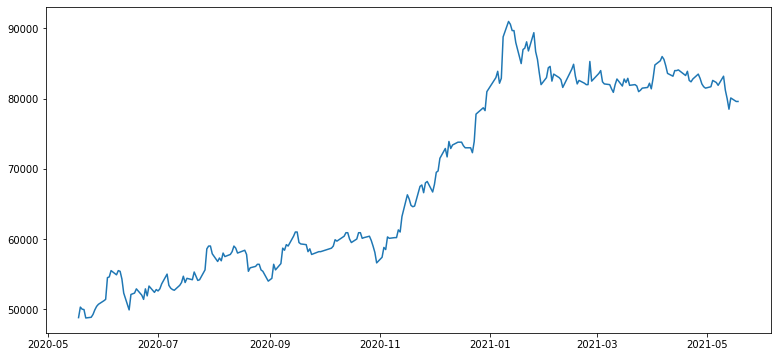

In [4]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6 

plt.plot(ts)

In [5]:
roll_mean5 = pd.Series.rolling(ts, window=5, center = False).mean()
roll_mean10 = pd.Series.rolling(ts, window=10, center = False).mean()
roll_mean20 = pd.Series.rolling(ts, window=20, center = False).mean()

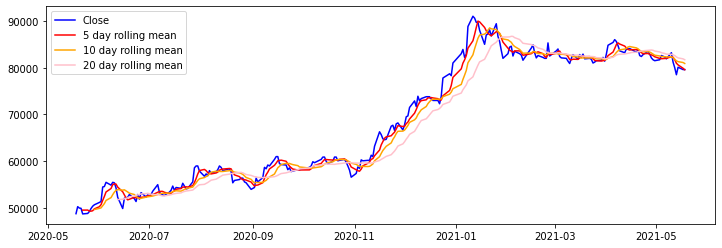

In [6]:
fig = plt.figure(figsize = (12, 4))
chart = fig.add_subplot(1,1,1)

chart.plot(ts, color='blue' , label='Close')
chart.plot(roll_mean5, color='red' , label='5 day rolling mean')
chart.plot(roll_mean10, color='orange' , label='10 day rolling mean')
chart.plot(roll_mean20, color='pink' , label='20 day rolling mean')
plt.legend(loc = 'best')

## 결측치 유무 확인

In [7]:
ts=ts.interpolate(method='time')
print(ts[ts.isna()])

#결측치는 없는것으로 판단됨

Series([], Name: Close, dtype: float64)


## 로그 변환

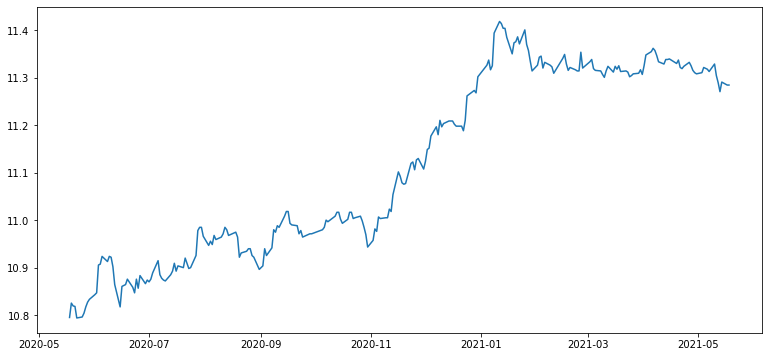

In [8]:
ts_log = np.log(ts)
plt.plot(ts_log)

# 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

## 정성적 그래프 분석
- 이동평균과 이동표준편차 시계열 그려보기

In [9]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

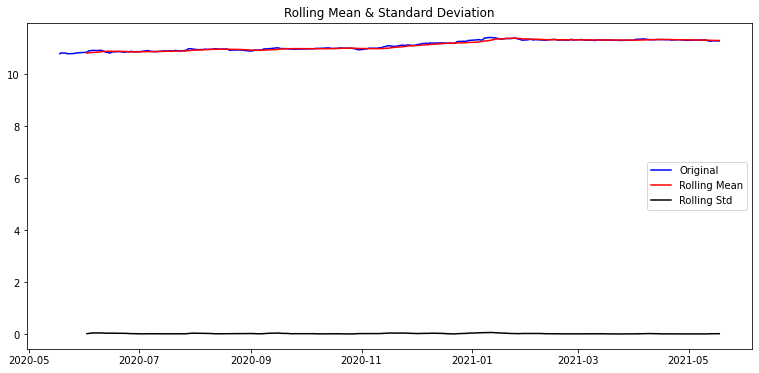

In [10]:
plot_rolling_statistics(ts_log, window=12)

## 정량적 Augmented Dicky-Fuller Test

In [11]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [12]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


- 현재 p-value의 값이 약 0.6이 나왔는데, 해당 데이터는 귀무가설(시계열이 안정적이지 않다.)을 기각할 수 없으므로, 안정적이지 않은 데이터로 판별됨

## 시계열 분해 (Time Series Decomposition)

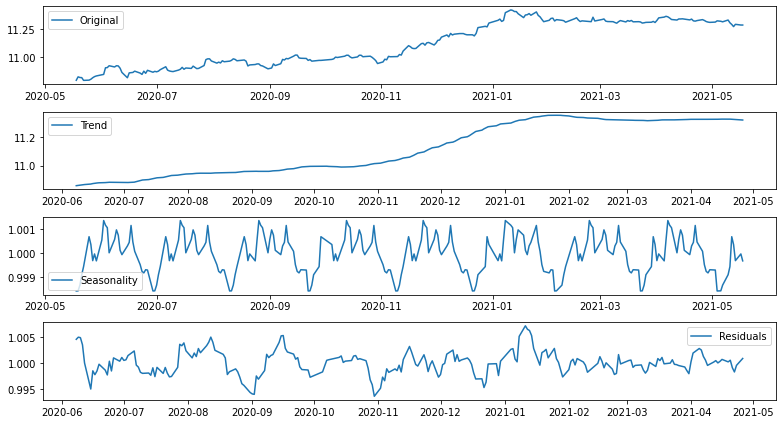

In [13]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## Residual 안정성 확인

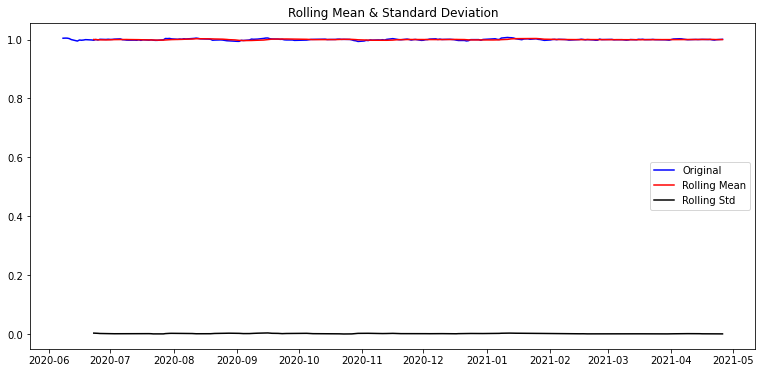

In [14]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [15]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


- p-value값이 통계적 유의성을 보임

# 학습, 테스트 데이터셋 생성

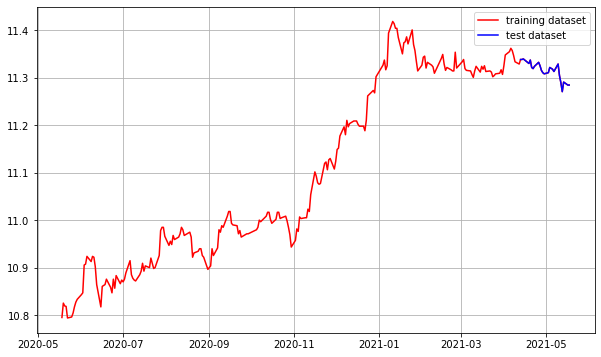

In [16]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [17]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-05-18    10.795486
2020-05-19    10.825760
Name: Close, dtype: float64
(225,)
(25,)


# 적정 ARIMA 모수 찾기
- ARIMA는 AR(Autoregressive) + I(Integrated) + MA(Moving Average)
- p : 자기회귀 모형(AR)의 시차
- d : 차분 누적(I) 횟수
- q : 이동평균 모형(MA)의 시차
- p,q 값을 구하기 위해선 plot_acf, plot_pacf를 사용하면 간편하게 그려낼 수 있음

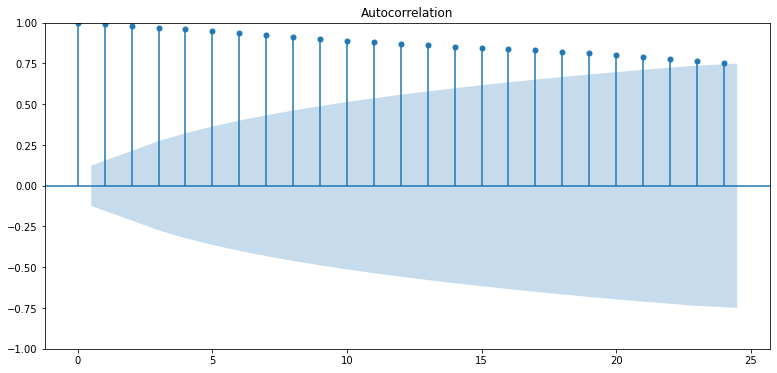

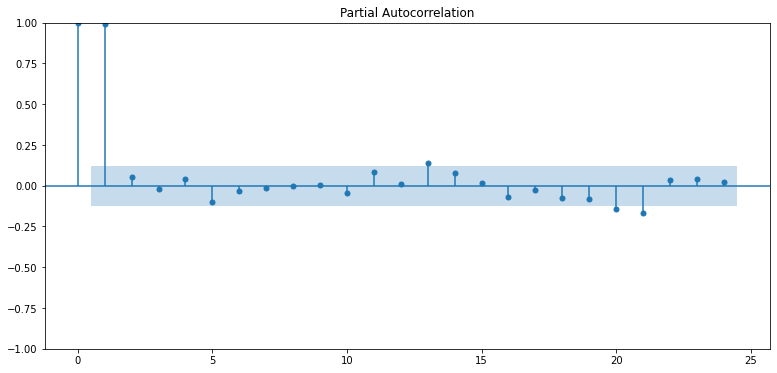

In [18]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


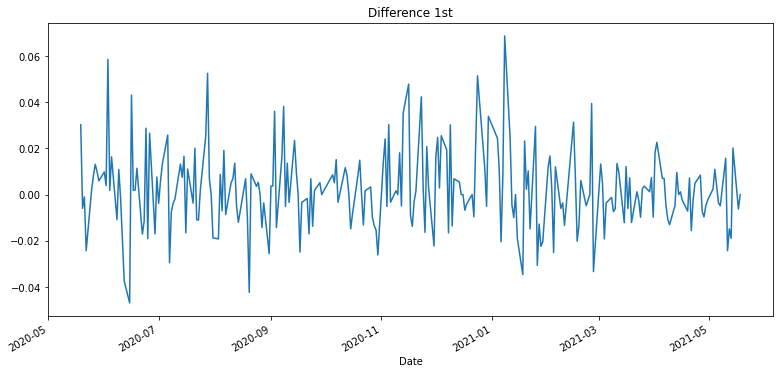

In [19]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

### 그래프 해석
|              |AR(p)모델 적합|AR(p)모델 적합|ARMA(p,q)모델 적합|
|--------------|--------------|--------------|--------------|
|  ACR 그래프  |점점 작아진다 |시차 p이후에 0|점점 작아진다|
|  PACF 그래프 |시차 p이후에 0|점점 작아진다 |점점 작아진다|

- ACF 그래프는 lag24 지점에서 신뢰구간에 진입하므로, MR(23) 모형이 적합하여 q=23으로 하는것이 좋아보임
- PACF 그래프는 lag2 지점에서 신뢰구간에 진입하므로, AR(1) 모형이 적합하여 p=1로 하는것이 좋아보임
- 1차 차분 결과, p-value값이 2.183738e-28으로 통계적으로 유의한 값임을 확인함

# ARIMA 모델 훈련과 추론

In [20]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1,0,23))
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(1, 0, 23)   Log Likelihood                 589.932
Date:                Mon, 27 Mar 2023   AIC                          -1127.863
Time:                        12:16:05   BIC                          -1039.045
Sample:                             0   HQIC                         -1092.016
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0765      0.200     55.401      0.000      10.685      11.468
ar.L1          0.9960      0.009    109.696      0.000       0.978       1.014
ma.L1          0.0533      0.074      0.723      0.4

## 훈련 결과 시각화

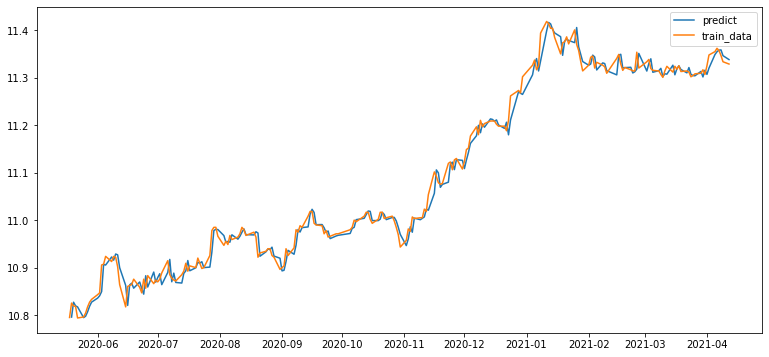

In [21]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

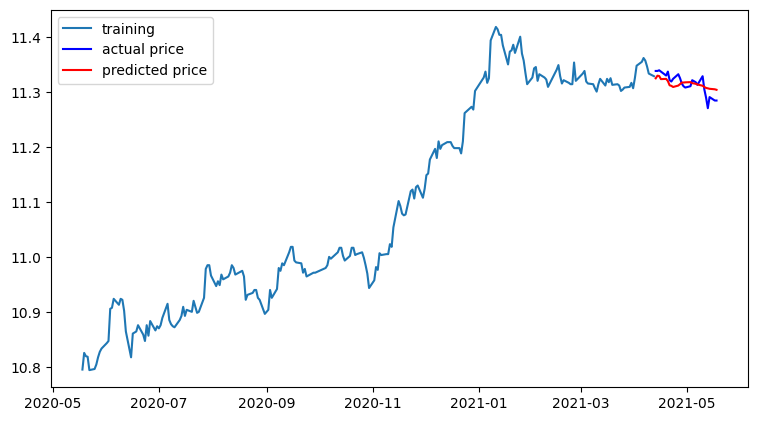

In [22]:
model = ARIMA(train_data, order=(1,0,23))
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

# 결과

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1324854.8135880912
MAE:  976.0134925437619
RMSE:  1151.0233766470997
MAPE: 1.19%


# 결과 해석
- ARIMA(1,0,23)모델을 통하여 삼성전자 주식 가격을 예측하여MAPE: 1.19% 성능을 보였음
- 차분을 했을때는 예측값이 1자로 되어 차분을 제외하고 예측을 하였음
- LMS 예제 상에는 (2,0,1)로 예측을 하였는데, 왜 그렇게 했는지 아직 이해는 제대로 가지 않음

# 2. 현대자동차 데이터 불러오기

In [24]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005380.KS.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates = True)
hd = df['Close']
hd.head()

Date
2022-03-28    174500.0
2022-03-29    176500.0
2022-03-30    181000.0
2022-03-31    180500.0
2022-04-01    178000.0
Name: Close, dtype: float64

# 데이터 EDA 및 전처리

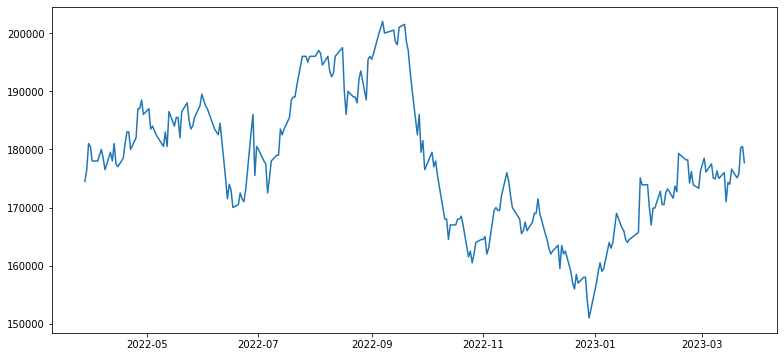

In [25]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6 

plt.plot(hd)

In [26]:
roll_mean5 = pd.Series.rolling(hd, window=5, center = False).mean()
roll_mean10 = pd.Series.rolling(hd, window=10, center = False).mean()
roll_mean20 = pd.Series.rolling(hd, window=20, center = False).mean()

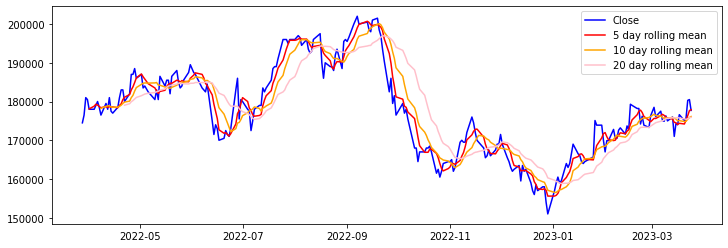

In [27]:
fig = plt.figure(figsize = (12, 4))
chart = fig.add_subplot(1,1,1)

chart.plot(hd, color='blue' , label='Close')
chart.plot(roll_mean5, color='red' , label='5 day rolling mean')
chart.plot(roll_mean10, color='orange' , label='10 day rolling mean')
chart.plot(roll_mean20, color='pink' , label='20 day rolling mean')
plt.legend(loc = 'best')

## 결측치 유무 확인

In [28]:
hd=hd.interpolate(method='time')
print(hd[hd.isna()])
#결측치는 없는것으로 판단됨

Series([], Name: Close, dtype: float64)


## 로그 변환

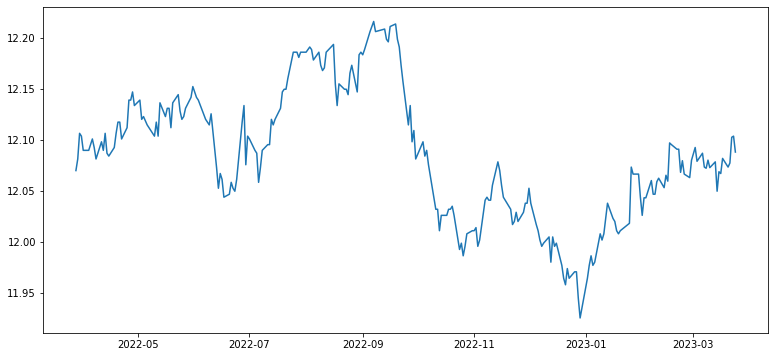

In [29]:
hd_log = np.log1p(hd)
plt.plot(hd_log)

# 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

## 정성적 그래프 분석
- 이동평균과 이동표준편차 시계열 그려보기

In [30]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

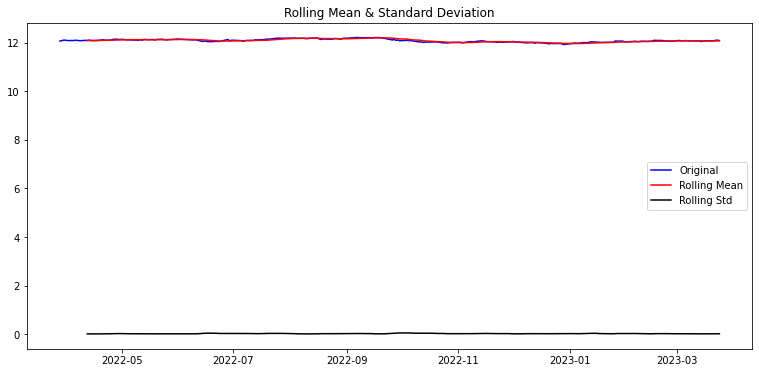

In [31]:
plot_rolling_statistics(hd_log, window=12)

## 정량적 Augmented Dicky-Fuller Test

In [32]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [33]:
augmented_dickey_fuller_test(hd_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.969599
p-value                          0.300060
#Lags Used                       0.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


- 현재 p-value의 값이 약 0.3이 나왔는데, 해당 데이터는 귀무가설(시계열이 안정적이지 않다.)을 기각할 수 없으므로, 안정적이지 않은 데이터로 판별됨

## 시계열 분해 (Time Series Decomposition)


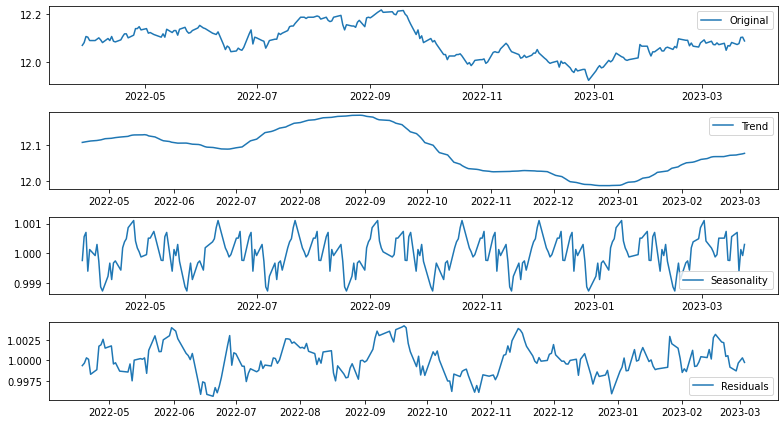

In [34]:
decomposition = seasonal_decompose(hd_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(hd_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## Residual 안정성 확인

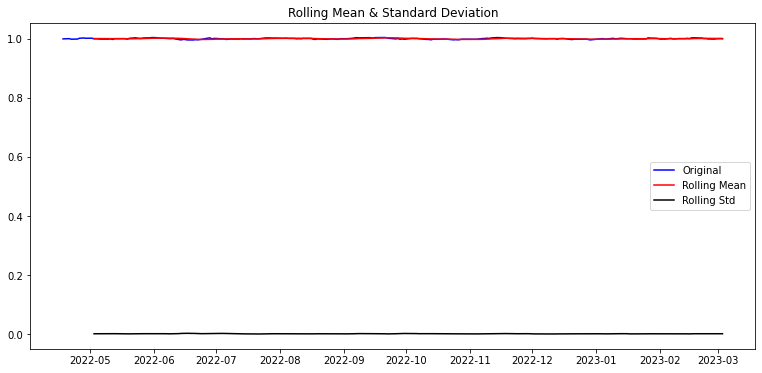

In [35]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [36]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.087562
p-value                          0.001015
#Lags Used                      13.000000
Number of Observations Used    203.000000
Critical Value (1%)             -3.462980
Critical Value (5%)             -2.875885
Critical Value (10%)            -2.574416
dtype: float64


- p-value값이 통계적 유의성을 보임

# 학습, 테스트 데이터셋 생성
- train 데이터와 test 데이터를 각각 90%, 10% 의 길이로 분리

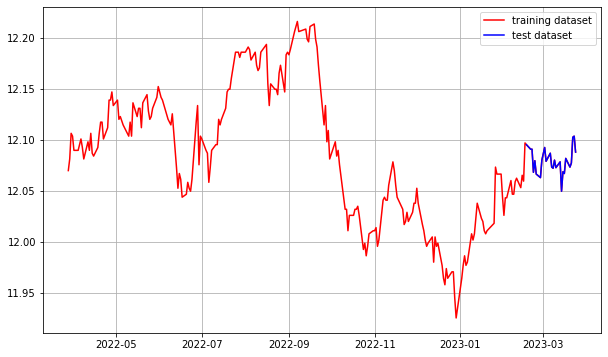

In [37]:
train_data, test_data = hd_log[:int(len(hd_log)*0.9)], hd_log[int(len(hd_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(hd_log, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [38]:
print(hd_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2022-03-28    12.069686
2022-03-29    12.081082
Name: Close, dtype: float64
(222,)
(25,)


# 적정 ARIMA 모수 찾기
- ARIMA는 AR(Autoregressive) + I(Integrated) + MA(Moving Average)
- p : 자기회귀 모형(AR)의 시차
- d : 차분 누적(I) 횟수
- q : 이동평균 모형(MA)의 시차
- p,q 값을 구하기 위해선 plot_acf, plot_pacf를 사용하면 간편하게 그려낼 수 있음

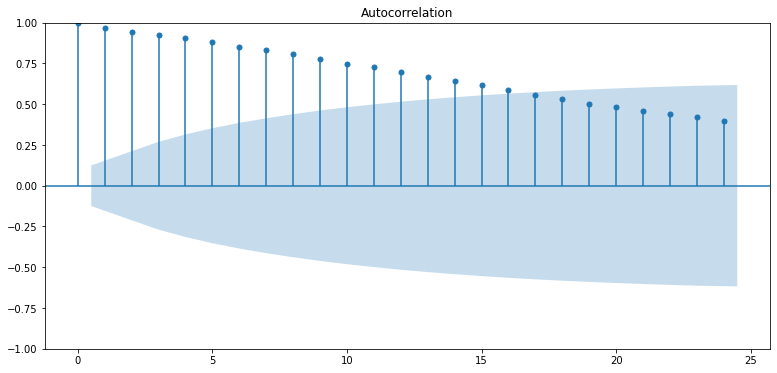

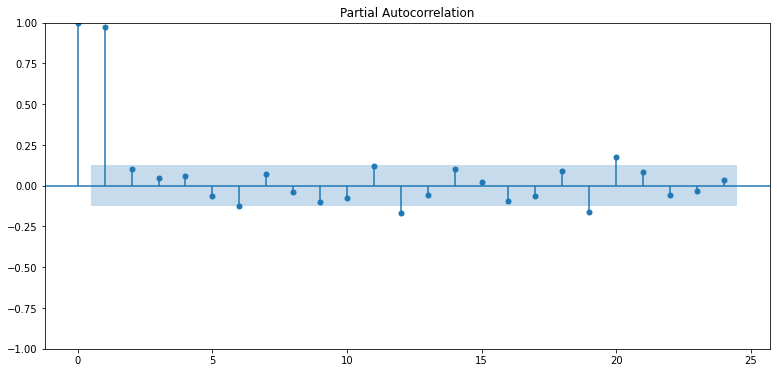

In [39]:
plot_acf(hd_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(hd_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

<AxesSubplot:title={'center':'Difference 1st'}, xlabel='Date'>

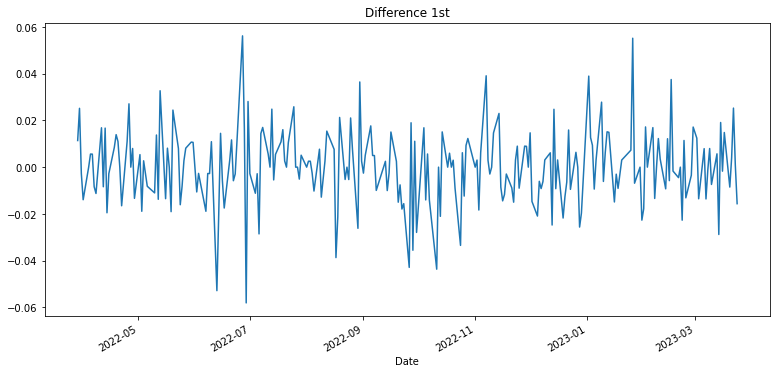

In [40]:
# 1차 차분 구하기
diff_1 = hd_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

In [41]:
augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.727619e+01
p-value                        5.819790e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


### 그래프 해석
- ACF 그래프는 lag17 지점에서 신뢰구간에 진입하므로, MR(16) 모형이 적합하여 q=16으로 하는것이 좋아보임
- PACF 그래프는 lag2 지점에서 신뢰구간에 진입하므로, AR(1) 모형이 적합하여 p=1로 하는것이 좋아보임
- 1차 차분 결과, p-value값이 5.819790e-30으로 통계적으로 유의한 값임을 확인함

# ARIMA 모델 훈련과 추론

In [152]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2,0,7))
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  222
Model:                 ARIMA(2, 0, 7)   Log Likelihood                 603.136
Date:                Sun, 26 Mar 2023   AIC                          -1184.272
Time:                        18:25:53   BIC                          -1146.842
Sample:                             0   HQIC                         -1169.160
                                - 222                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0843      0.036    332.254      0.000      12.013      12.156
ar.L1          0.8477      2.962      0.286      0.775      -4.957       6.652
ar.L2          0.1201      2.872      0.042      0.9

## 훈련 결과 시각화

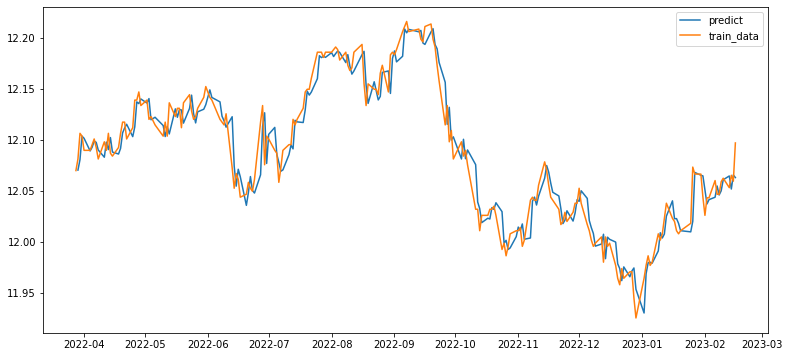

In [142]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

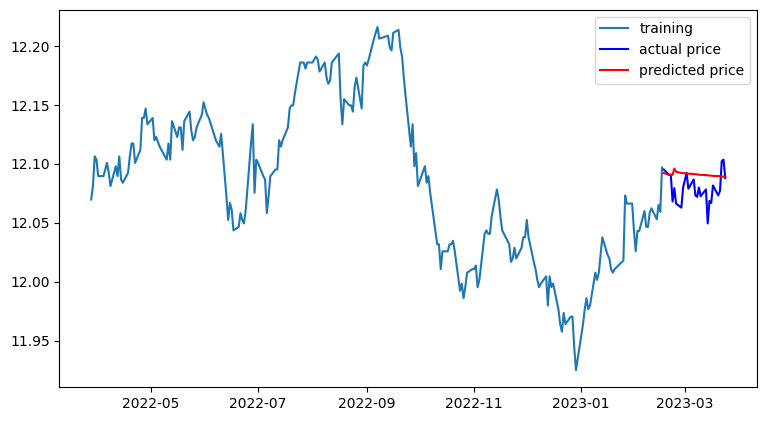

In [153]:
model = ARIMA(train_data, order=(2,0,7))
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

# 결과

In [154]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  9342265.47267623
MAE:  2526.184646220683
RMSE:  3056.5119781666535
MAPE: 1.44%


# 결과 해석
- ARIMA(2,0,7)모델을 통하여 현대자동차 주식 가격을 예측하여 MAPE: 1.44% 성능을 보였음
- 그래프의 결과로는 ARIMA(1,0,16)모델이 나왔지만, 다양한 파라미터값을 사용해본 결과 해당 파라미터의 MAPE값이 가장 낮았음 

# 3. sk하이닉스 데이터 불러오기

In [42]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/000660.KS.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates = True)
sk = df['Close']
sk.head()

Date
2022-03-28    118000.0
2022-03-29    120000.0
2022-03-30    121000.0
2022-03-31    118000.0
2022-04-01    116000.0
Name: Close, dtype: float64

# 데이터 EDA 및 전처리

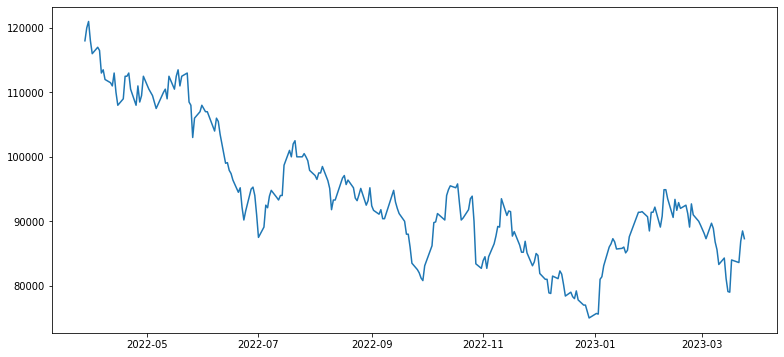

In [43]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6 

plt.plot(sk)

In [44]:
roll_mean5 = pd.Series.rolling(sk, window=5, center = False).mean()
roll_mean10 = pd.Series.rolling(sk, window=10, center = False).mean()
roll_mean20 = pd.Series.rolling(sk, window=20, center = False).mean()

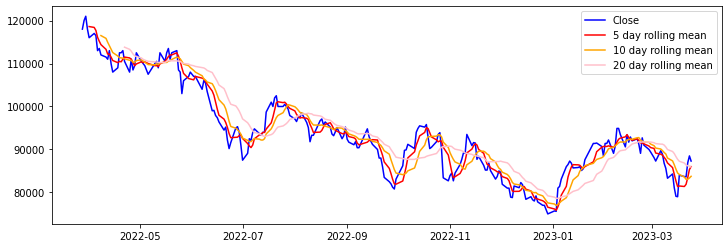

In [46]:
fig = plt.figure(figsize = (12, 4))
chart = fig.add_subplot(1,1,1)

chart.plot(sk, color='blue' , label='Close')
chart.plot(roll_mean5, color='red' , label='5 day rolling mean')
chart.plot(roll_mean10, color='orange' , label='10 day rolling mean')
chart.plot(roll_mean20, color='pink' , label='20 day rolling mean')
plt.legend(loc = 'best')

## 결측치 유무 확인

In [48]:
sk=sk.interpolate(method='time')
print(sk[sk.isna()])
#결측치는 없는것으로 판단됨

Series([], Name: Close, dtype: float64)


## 로그 변환

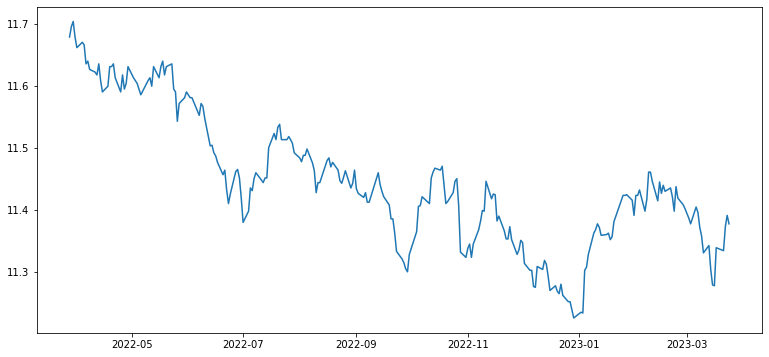

In [49]:
sk_log = np.log(sk)
plt.plot(sk_log)

# 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

## 정성적 그래프 분석
- 이동평균과 이동표준편차 시계열 그려보기

In [50]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

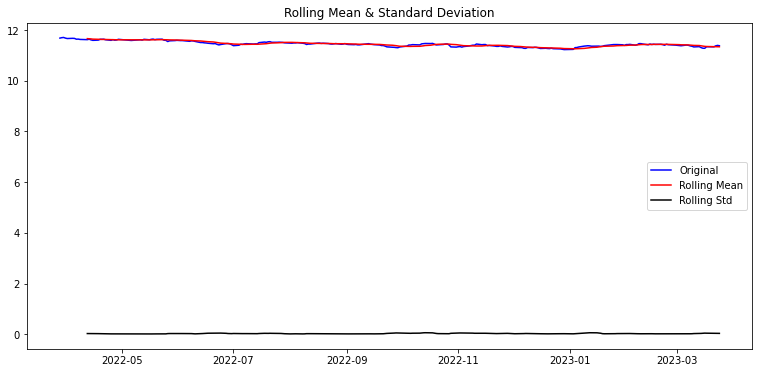

In [51]:
plot_rolling_statistics(sk_log, window=12)

## 정량적 Augmented Dicky-Fuller Test

In [52]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [53]:
augmented_dickey_fuller_test(sk_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.244100
p-value                          0.190631
#Lags Used                       0.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


- 현재 p-value의 값이 약 0.2가 나왔는데, 해당 데이터는 귀무가설(시계열이 안정적이지 않다.)을 기각할 수 없으므로, 안정적이지 않은 데이터로 판별됨

## 시계열 분해 (Time Series Decomposition)

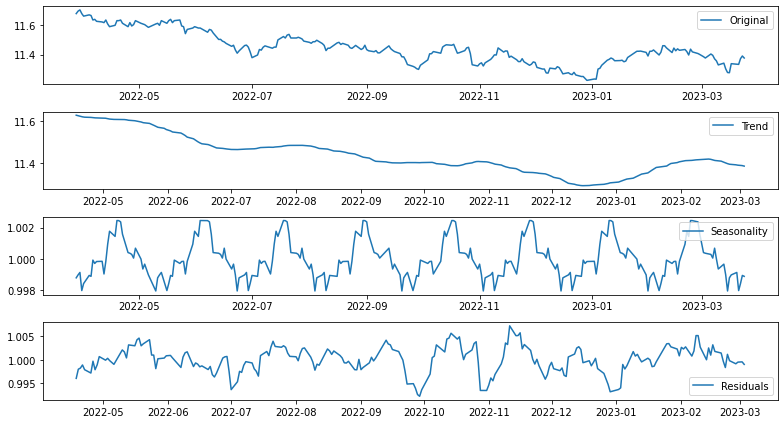

In [54]:
decomposition = seasonal_decompose(sk_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(sk_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## Residual 안정성 확인

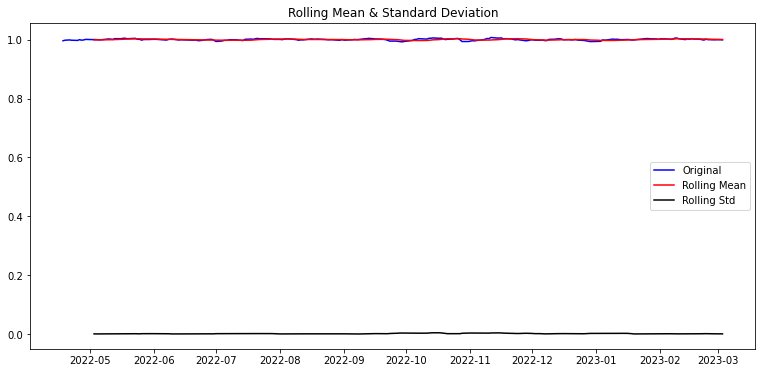

In [55]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [56]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.031315
p-value                          0.000019
#Lags Used                       1.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64


- p-value값이 통계적 유의성을 보임

# 학습, 테스트 데이터셋 생성

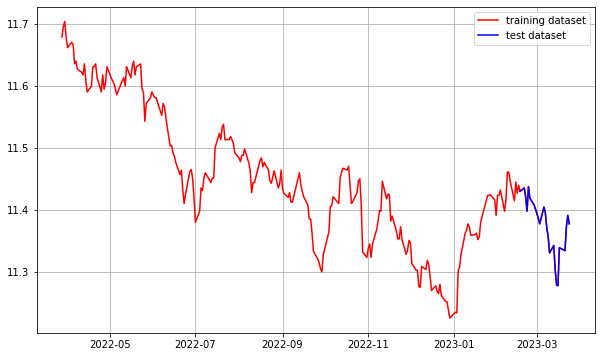

In [58]:
train_data, test_data = sk_log[:int(len(sk_log)*0.9)], sk_log[int(len(sk_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(sk_log, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [59]:
print(sk_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2022-03-28    11.678440
2022-03-29    11.695247
Name: Close, dtype: float64
(222,)
(25,)


# 적정 ARIMA 모수 찾기
- ARIMA는 AR(Autoregressive) + I(Integrated) + MA(Moving Average)
- p : 자기회귀 모형(AR)의 시차
- d : 차분 누적(I) 횟수
- q : 이동평균 모형(MA)의 시차
- p,q 값을 구하기 위해선 plot_acf, plot_pacf를 사용하면 간편하게 그려낼 수 있음

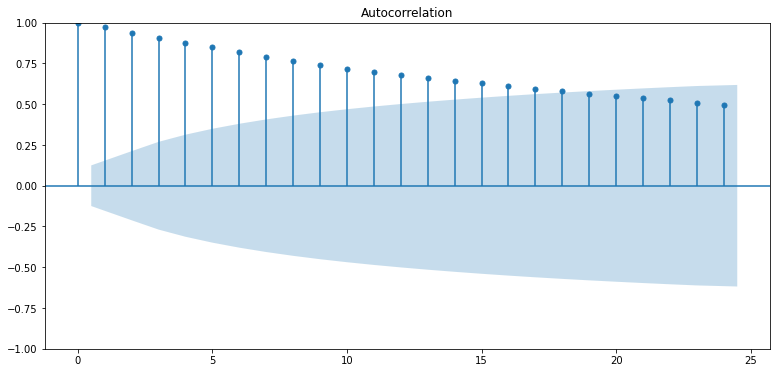

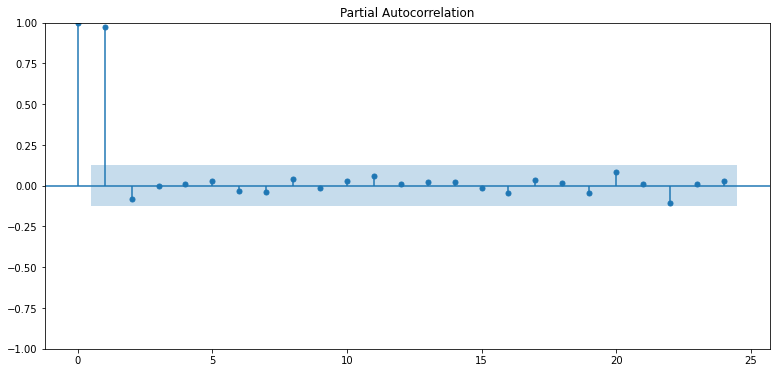

In [60]:
plot_acf(sk_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(sk_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.477591e+01
p-value                        2.284425e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


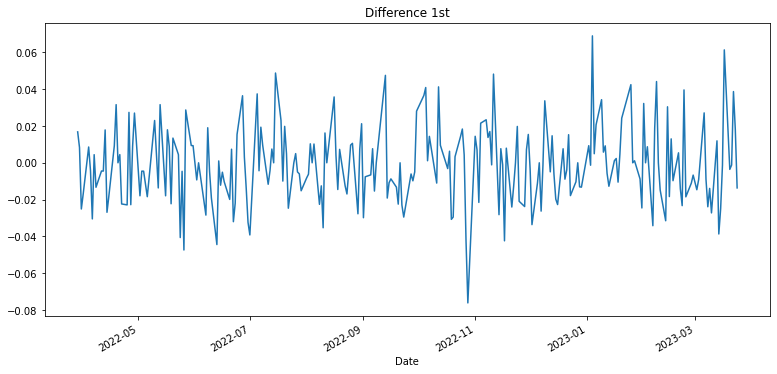

In [61]:
# 1차 차분 구하기
diff_1 = sk_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

### 그래프 해석
- ACF 그래프는 lag18 지점에서 신뢰구간에 진입하므로, MR(17) 모형이 적합하여 q=17으로 하는것이 좋아보임
- PACF 그래프는 lag2 지점에서 신뢰구간에 진입하므로, AR(1) 모형이 적합하여 p=1로 하는것이 좋아보임
- 1차 차분 결과, p-value값이 2.284425e-27으로 통계적으로 유의한 값임을 확인함

In [78]:
# ARIMA 모델 훈련과 추론
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1,0,17))
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  222
Model:                ARIMA(1, 0, 17)   Log Likelihood                 551.066
Date:                Mon, 27 Mar 2023   AIC                          -1062.131
Time:                        13:09:20   BIC                           -994.078
Sample:                             0   HQIC                         -1034.656
                                - 222                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4887      0.060    191.051      0.000      11.371      11.607
ar.L1          0.9858      0.014     70.033      0.000       0.958       1.013
ma.L1          0.0758      0.076      1.003      0.3

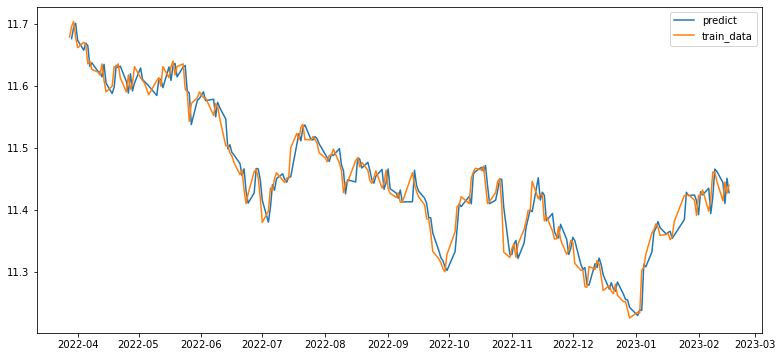

In [75]:
## 훈련 결과 시각화

fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

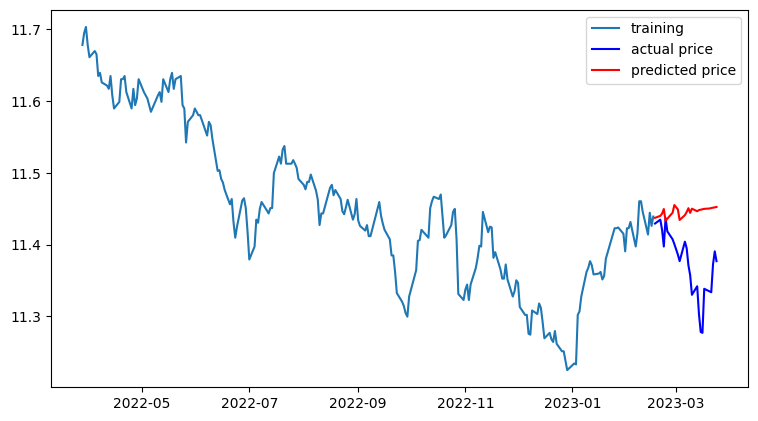

In [79]:
model = ARIMA(train_data, order=(1,0,17))
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [80]:
# 결과
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  60294017.02668367
MAE:  6580.6475212051055
RMSE:  7764.922216396226
MAPE: 7.79%


# 결과 해석
- ARIMA(1,0,17)모델을 통하여 sk 하이닉스 주식 가격을 예측하여 MAPE: 7.79% 성능을 보였음
- 그래프의 결과로는 주식가격을 제대로 예측하지 못하는 것으로 보이지만 성능지표인 MAPE는 7.79%의 성능을 보였음

# 전체적인 회고
- 시계열, ARIMA 모델에 대해 처음으로 제대로 공부를 해보았습니다. 종가만 가지고 주식 가격을 예측한다는 것은 신의 영역이라고 생각이 됩니다. 특히 우리나라 주식시장은 미국, 북한의 영향을 가장 많이 받으므로 예측을 할 수 없는 범위라고 생각이 됩니다. 하지만 항상 흥미가 있던 분야인 주식 가격을 시계열로 예측해보는 것은 재미있었습니다.
- plot_acf, plot_pacf을 통해 적정한 p, d, q를 찾는 것은 아직 제대로 이해한것은 아닙니다. 또한 summary값을 통해 나온 결과해석에서도 p-value값은 분명히 높은데 성능지표인 MAPE값은 낮게 나오는것이 의문입니다.
- 다양한 값들로 분석을 통해 적절한 값을 찾는 것이 중요하다고 느꼈습니다.
- 이번 기회에 시계열에 대해 정리를 잘 해야겠다는 생각이 들었고, 많은 레퍼런스를 찾아보며 열심히 공부를 하겠습니다.

# 참고
- https://joyfuls.tistory.com/54
- https://otexts.com/fppkr/non-seasonal-arima.html
- https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=khrock89&logNo=220171772873
- https://assaeunji.github.io/statistics/2021-09-08-arimapdq/
- https://leedakyeong.tistory.com/entry/ARIMA%EB%9E%80-ARIMA-%EB%B6%84%EC%84%9D%EA%B8%B0%EB%B2%95-AR-MA-ACF-PACF-%EC%A0%95%EC%83%81%EC%84%B1%EC%9D%B4%EB%9E%80
- https://hwao-story.tistory.com/13